In [353]:
"""
# OLA DRIVER ATTRITION ANALYSIS

## Problem Statement
Recruiting and retaining drivers is a tough battle for Ola. High churn impacts morale and
acquisition costs are higher than retention costs. This analysis predicts driver attrition
using demographics, performance, and tenure data to provide actionable retention strategies.

## Dataset Overview
- Monthly driver data for 2019-2020
- Demographics: age, gender, city, education
- Performance: quarterly rating, business value, grade
- Timeline: joining date, last working date
"""
pass

In [375]:

# =============================================================================
# CELL 1: IMPORT LIBRARIES AND SETUP
# =============================================================================

"""
### 1. Import Required Libraries
Setting up the environment with all necessary libraries for data analysis, visualization, and machine learning.
"""

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")

# Set all pandas display options to show full output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# To reset back to default limits
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

print("All libraries imported successfully!")
print("Environment setup complete.")


All libraries imported successfully!
Environment setup complete.


In [356]:

# =============================================================================
# CELL 2: DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

"""
### 2. Data Loading and Initial Exploration
Loading the Ola driver dataset and performing initial data exploration to understand structure,
data types, and basic characteristics.
"""

# Load the dataset
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv"
df = pd.read_csv(url)
_data = df.copy()  # Keep original data safe

print("=== INITIAL DATA EXPLORATION ===")
print(f"Dataset shape: {_data.shape}")
print(f"\nDataset Info:")
_data.info()
print(f"\nFirst 5 rows:")
display(_data.head())
print(f"\nColumn names: {list(_data.columns)}")

=== INITIAL DATA EXPLORATION ===
Dataset shape: (19104, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1



Column names: ['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating']


In [357]:
# =============================================================================
# CELL 3: DATA CLEANING AND MISSING VALUES ANALYSIS
# =============================================================================

"""
### 3. Data Cleaning and Missing Values Analysis
Cleaning the dataset by removing unnecessary columns and analyzing missing values pattern
to understand data quality issues.
"""

# Drop the unnecessary index column
_data = _data.drop(columns='Unnamed: 0')
print("=== DATA CLEANING ===")
print(f"Dataset shape after cleaning: {_data.shape}")

# Detailed missing values analysis
print(f"\n=== MISSING VALUES ANALYSIS ===")
missing_values = _data.isnull().sum()
missing_percentage = (_data.isnull().sum() / len(_data)) * 100

missing_df = pd.DataFrame({
    'Column': _data.columns,
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percentage
})
print("Missing values summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

print(f"\n=== BASIC STATISTICS ===")
print(f"Total unique drivers: {_data['Driver_ID'].nunique()}")
print(f"Date range: {_data['MMM-YY'].min()} to {_data['MMM-YY'].max()}")
print(f"Unique cities: {_data['City'].nunique()}")

=== DATA CLEANING ===
Dataset shape after cleaning: (19104, 13)

=== MISSING VALUES ANALYSIS ===
Missing values summary:
                          Column  Missing_Count  Missing_Percentage
Age                          Age             61              0.3193
Gender                    Gender             52              0.2722
LastWorkingDate  LastWorkingDate          17488             91.5410

=== BASIC STATISTICS ===
Total unique drivers: 2381
Date range: 01/01/19 to 12/01/20
Unique cities: 29


In [358]:
# =============================================================================
# CELL 4: DATE CONVERSION
# =============================================================================

"""
### 4. Date Features Conversion
Converting date columns from string to proper datetime format for analysis and feature engineering.
"""

print("=== DATE CONVERSION ===")
print("Before conversion:")
print(_data[['MMM-YY', 'Dateofjoining', 'LastWorkingDate']].dtypes)

# Convert date columns to datetime
_data['MMM-YY'] = pd.to_datetime(_data['MMM-YY'], format='%d/%m/%y')
_data['Dateofjoining'] = pd.to_datetime(_data['Dateofjoining'], format='%d/%m/%y')
_data['LastWorkingDate'] = pd.to_datetime(_data['LastWorkingDate'], format='%d/%m/%y')

print("\nAfter conversion:")
print(_data[['MMM-YY', 'Dateofjoining', 'LastWorkingDate']].dtypes)
print(f"\nDate ranges:")
print(f"Reporting period: {_data['MMM-YY'].min()} to {_data['MMM-YY'].max()}")
print(f"Joining dates: {_data['Dateofjoining'].min()} to {_data['Dateofjoining'].max()}")

=== DATE CONVERSION ===
Before conversion:
MMM-YY             object
Dateofjoining      object
LastWorkingDate    object
dtype: object

After conversion:
MMM-YY             datetime64[ns]
Dateofjoining      datetime64[ns]
LastWorkingDate    datetime64[ns]
dtype: object

Date ranges:
Reporting period: 2019-01-01 00:00:00 to 2020-01-12 00:00:00
Joining dates: 2013-01-04 00:00:00 to 2020-12-28 00:00:00


In [359]:

# =============================================================================
# CELL 5: TARGET VARIABLE UNDERSTANDING
# =============================================================================

"""
### 5. Target Variable Analysis
Understanding the true attrition rate by analyzing unique drivers who left vs. those still active.
This is crucial for understanding the business problem scope.
"""

print("=== TARGET VARIABLE ANALYSIS ===")
drivers_who_left = _data[_data['LastWorkingDate'].notna()]['Driver_ID'].nunique()
total_unique_drivers = _data['Driver_ID'].nunique()
drivers_still_active = total_unique_drivers - drivers_who_left

print(f"Total unique drivers: {total_unique_drivers}")
print(f"Drivers who left (have LastWorkingDate): {drivers_who_left}")
print(f"Drivers still active: {drivers_still_active}")
print(f"Attrition rate: {(drivers_who_left/total_unique_drivers)*100:.2f}%")
print(f"Retention rate: {(drivers_still_active/total_unique_drivers)*100:.2f}%")


=== TARGET VARIABLE ANALYSIS ===
Total unique drivers: 2381
Drivers who left (have LastWorkingDate): 1616
Drivers still active: 765
Attrition rate: 67.87%
Retention rate: 32.13%


In [360]:
# =============================================================================
# CELL 6: KNN IMPUTATION PREPARATION
# =============================================================================

"""
### 6. KNN Imputation - Data Preparation
Preparing numerical data for KNN imputation to handle missing values in Age and Gender columns.
KNN imputation uses similarity between drivers to fill missing values intelligently.
"""

print("=== KNN IMPUTATION PREPARATION ===")
print("Missing values before imputation:")
print(_data.isnull().sum()[_data.isnull().sum() > 0])

# Select numerical columns for KNN imputation
_data_nums = _data.select_dtypes(include=[np.number])
print(f"\nNumerical columns shape: {_data_nums.shape}")

# Remove Driver_ID from numerical columns for imputation
_data_nums = _data_nums.drop(columns='Driver_ID')
columns = _data_nums.columns
print(f"Columns for KNN imputation: {list(columns)}")

=== KNN IMPUTATION PREPARATION ===
Missing values before imputation:
Age                   61
Gender                52
LastWorkingDate    17488
dtype: int64

Numerical columns shape: (19104, 9)
Columns for KNN imputation: ['Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating']


In [361]:
# =============================================================================
# CELL 7: APPLY KNN IMPUTATION
# =============================================================================

"""
### 7. Apply KNN Imputation
Using KNN imputation with 5 nearest neighbors to fill missing Age and Gender values
based on similarity with other drivers' characteristics.
"""

print("=== APPLYING KNN IMPUTATION ===")
# Apply KNN Imputation with 5 nearest neighbors
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
print("Fitting KNN Imputer...")
_data_new = imputer.fit_transform(_data_nums)

# Convert back to DataFrame
_data_new = pd.DataFrame(_data_new, columns=columns)
print("KNN Imputation completed!")

print(f"\nMissing values after imputation:")
print(_data_new.isnull().sum())
print(f"Age missing values fixed: {_data_nums['Age'].isnull().sum()} → {_data_new['Age'].isnull().sum()}")
print(f"Gender missing values fixed: {_data_nums['Gender'].isnull().sum()} → {_data_new['Gender'].isnull().sum()}")

=== APPLYING KNN IMPUTATION ===
Fitting KNN Imputer...
KNN Imputation completed!

Missing values after imputation:
Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
dtype: int64
Age missing values fixed: 61 → 0
Gender missing values fixed: 52 → 0


In [362]:
# =============================================================================
# CELL 8: RECONSTRUCT COMPLETE DATASET
# =============================================================================

"""
### 8. Reconstruct Complete Dataset
Combining the imputed numerical data with the remaining categorical and date columns
to create a complete dataset with no missing values in key features.
"""

print("=== DATASET RECONSTRUCTION ===")
# Get remaining columns
numerical_cols = list(columns)
all_cols = list(_data.columns)
remaining_columns = [col for col in all_cols if col not in numerical_cols]

# Combine imputed data with remaining columns
data = pd.concat([_data_new, _data[remaining_columns]], axis=1)
print(f"Reconstructed dataset shape: {data.shape}")

# Verify reconstruction
print(f"\nMissing values check:")
print(f"Age missing: {data['Age'].isnull().sum()}")
print(f"Gender missing: {data['Gender'].isnull().sum()}")
print(f"LastWorkingDate missing: {data['LastWorkingDate'].isnull().sum()} (expected - active drivers)")

=== DATASET RECONSTRUCTION ===
Reconstructed dataset shape: (19104, 13)

Missing values check:
Age missing: 0
Gender missing: 0
LastWorkingDate missing: 17488 (expected - active drivers)


In [363]:
# =============================================================================
# CELL 9: DATA AGGREGATION - MONTH LEVEL
# =============================================================================

"""
### 9. Data Aggregation - Driver-Month Level
Aggregating monthly records by Driver ID and month to handle multiple entries per driver-month.
This step prepares data for driver-level aggregation.
"""

print("=== DATA AGGREGATION - MONTH LEVEL ===")
# Define aggregation functions for each column
function_dict = {
    'Age': 'max',
    'Gender': 'first',
    'City': 'first',
    'Education_Level': 'last',
    'Income': 'last',
    'Joining Designation': 'last',
    'Grade': 'last',
    'Dateofjoining': 'last',
    'LastWorkingDate': 'last',
    'Total Business Value': 'sum',
    'Quarterly Rating': 'last'
}

# Aggregate by Driver_ID and MMM-YY
new_train = data.groupby(['Driver_ID', 'MMM-YY']).agg(function_dict).reset_index()
new_train = new_train.sort_values(['Driver_ID', 'MMM-YY']).reset_index(drop=True)

print(f"Shape after Driver+Month aggregation: {new_train.shape}")
print("Sample of aggregated data:")
display(new_train.head(10))

=== DATA AGGREGATION - MONTH LEVEL ===
Shape after Driver+Month aggregation: (19104, 13)
Sample of aggregated data:


,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating
0,1,2019-01-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,NaT,2381060.0,2.0
1,1,2019-01-02,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,NaT,-665480.0,2.0
2,1,2019-01-03,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-11-03,0.0,2.0
3,2,2020-01-11,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-06-11,NaT,0.0,1.0
4,2,2020-01-12,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-06-11,NaT,0.0,1.0
5,4,2019-01-12,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-07-12,NaT,0.0,1.0
6,4,2020-01-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-07-12,NaT,0.0,1.0
7,4,2020-01-02,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-07-12,NaT,0.0,1.0
8,4,2020-01-03,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-07-12,NaT,350000.0,1.0
9,4,2020-01-04,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-07-12,2020-04-27,0.0,1.0


In [364]:
# =============================================================================
# CELL 10: DATA AGGREGATION - DRIVER LEVEL
# =============================================================================

"""
### 10. Final Driver-Level Aggregation
Creating one record per driver by aggregating all their monthly data into driver-level features.
This creates the final dataset for machine learning with one row per driver.
"""

print("=== DRIVER-LEVEL AGGREGATION ===")
# Create driver-level dataset
df1 = pd.DataFrame()
df1['Driver_ID'] = new_train['Driver_ID'].unique()

# Aggregate features at driver level
df1['Age'] = new_train.groupby('Driver_ID')['Age'].max().values
df1['Gender'] = new_train.groupby('Driver_ID')['Gender'].first().values
df1['City'] = new_train.groupby('Driver_ID')['City'].first().values
df1['Education'] = new_train.groupby('Driver_ID')['Education_Level'].last().values
df1['Income'] = new_train.groupby('Driver_ID')['Income'].last().values
df1['Joining_Designation'] = new_train.groupby('Driver_ID')['Joining Designation'].last().values
df1['Grade'] = new_train.groupby('Driver_ID')['Grade'].last().values
df1['Dateofjoining'] = new_train.groupby('Driver_ID')['Dateofjoining'].first().values
df1['LastWorkingDate'] = new_train.groupby('Driver_ID')['LastWorkingDate'].last().values
df1['Total_Business_Value'] = new_train.groupby('Driver_ID')['Total Business Value'].sum().values
df1['Last_Quarterly_Rating'] = new_train.groupby('Driver_ID')['Quarterly Rating'].last().values

print(f"Driver-level dataset shape: {df1.shape}")
print("Sample of driver-level data:")
display(df1.head(10))

# Verify aggregation
active_drivers = df1['LastWorkingDate'].isna().sum()
left_drivers = df1['LastWorkingDate'].notna().sum()
print(f"\nVerification - Active drivers: {active_drivers}, Left drivers: {left_drivers}")

=== DRIVER-LEVEL AGGREGATION ===
Driver-level dataset shape: (2381, 12)
Sample of driver-level data:


,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Dateofjoining,LastWorkingDate,Total_Business_Value,Last_Quarterly_Rating
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-11-03,1.7156e+06,2.0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-06-11,NaT,0.0000e+00,1.0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-07-12,2020-04-27,3.5000e+05,1.0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-09-01,2019-07-03,1.2036e+05,1.0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1.2650e+06,2.0
5,8,34.0,0.0,C2,0.0,70656.0,3.0,3.0,2020-09-19,2020-11-15,0.0000e+00,1.0
6,11,28.0,1.0,C19,2.0,42172.0,1.0,1.0,2020-07-12,NaT,0.0000e+00,1.0
7,12,35.0,0.0,C23,2.0,28116.0,1.0,1.0,2019-06-29,2019-12-21,2.6072e+06,1.0
8,13,31.0,0.0,C19,2.0,119227.0,1.0,4.0,2015-05-28,2020-11-25,1.0213e+07,1.0
9,14,39.0,1.0,C26,0.0,19734.0,3.0,3.0,2020-10-16,NaT,0.0000e+00,1.0



Verification - Active drivers: 765, Left drivers: 1616


In [365]:
# =============================================================================
# CELL 11: FEATURE ENGINEERING - QUARTERLY RATING INCREASED
# =============================================================================

"""
### 11. Feature Engineering - Quarterly Rating Increased
Creating a behavioral feature to capture whether a driver's performance improved over time.
This compares first vs last quarterly rating to identify drivers showing improvement.
"""

print("=== FEATURE ENGINEERING - QUARTERLY RATING INCREASED ===")
# Get first and last quarterly ratings for each driver
first_rating = new_train.groupby('Driver_ID')['Quarterly Rating'].first()
last_rating = new_train.groupby('Driver_ID')['Quarterly Rating'].last()

# Create boolean feature: Did quarterly rating increase?
rating_increased = (last_rating > first_rating)
drivers_with_improvement = rating_increased.sum()

print(f"Drivers with rating improvement: {drivers_with_improvement}")
print(f"Percentage with improvement: {(drivers_with_improvement/len(rating_increased)*100):.2f}%")

# Add to main dataframe
df1['Quarterly_Rating_Increased'] = rating_increased.values.astype(int)
print(f"Quarterly Rating Increased distribution:")
print(df1['Quarterly_Rating_Increased'].value_counts())


=== FEATURE ENGINEERING - QUARTERLY RATING INCREASED ===
Drivers with rating improvement: 358
Percentage with improvement: 15.04%
Quarterly Rating Increased distribution:
Quarterly_Rating_Increased
0    2023
1     358
Name: count, dtype: int64


In [366]:

# =============================================================================
# CELL 12: FEATURE ENGINEERING - TARGET VARIABLE CREATION
# =============================================================================

"""
### 12. Target Variable Creation
Creating the target variable for our machine learning model:
- Target = 1: Driver left the company (has LastWorkingDate)
- Target = 0: Driver still active (no LastWorkingDate)
"""

print("=== TARGET VARIABLE CREATION ===")
# Create target variable based on LastWorkingDate
df1['Target'] = df1['LastWorkingDate'].notna().astype(int)

print("Target Variable Distribution:")
print(df1['Target'].value_counts())

target_percentages = df1['Target'].value_counts(normalize=True) * 100
print(f"\nTarget Variable Percentages:")
print(f"Active drivers (0): {target_percentages[0]:.2f}%")
print(f"Left drivers (1): {target_percentages[1]:.2f}%")

# Verify logic
print(f"\nVerification:")
print(f"Drivers with LastWorkingDate: {df1['LastWorkingDate'].notna().sum()}")
print(f"Target=1 count: {(df1['Target']==1).sum()}")
print(f"Match: {df1['LastWorkingDate'].notna().sum() == (df1['Target']==1).sum()}")


=== TARGET VARIABLE CREATION ===
Target Variable Distribution:
Target
1    1616
0     765
Name: count, dtype: int64

Target Variable Percentages:
Active drivers (0): 32.13%
Left drivers (1): 67.87%

Verification:
Drivers with LastWorkingDate: 1616
Target=1 count: 1616
Match: True


In [367]:
# =============================================================================
# CELL 13: FEATURE ENGINEERING - INCOME INCREASED
# =============================================================================

"""
### 13. Feature Engineering - Income Increased
Creating a feature to capture financial growth of drivers over time.
This compares first vs last income to identify drivers with salary improvements.
"""

print("=== FEATURE ENGINEERING - INCOME INCREASED ===")
# Get first and last income for each driver
first_income = new_train.groupby('Driver_ID')['Income'].first()
last_income = new_train.groupby('Driver_ID')['Income'].last()

# Create boolean feature: Did income increase?
income_increased = (last_income > first_income)
drivers_with_income_increase = income_increased.sum()

print(f"Drivers with income increase: {drivers_with_income_increase}")
print(f"Percentage with income increase: {(drivers_with_income_increase/len(income_increased)*100):.2f}%")

# Add to main dataframe
df1['Income_Increased'] = income_increased.values.astype(int)
print(f"Income Increased distribution:")
print(df1['Income_Increased'].value_counts())

# Show income change statistics
income_change = last_income - first_income
print(f"\nIncome change statistics:")
print(f"Average income change: {income_change.mean():.2f}")
print(f"Median income change: {income_change.median():.2f}")

print(f"\nFinal dataset shape: {df1.shape}")
print(f"All features: {list(df1.columns)}")


=== FEATURE ENGINEERING - INCOME INCREASED ===
Drivers with income increase: 43
Percentage with income increase: 1.81%
Income Increased distribution:
Income_Increased
0    2338
1      43
Name: count, dtype: int64

Income change statistics:
Average income change: 125.10
Median income change: 0.00

Final dataset shape: (2381, 15)
All features: ['Driver_ID', 'Age', 'Gender', 'City', 'Education', 'Income', 'Joining_Designation', 'Grade', 'Dateofjoining', 'LastWorkingDate', 'Total_Business_Value', 'Last_Quarterly_Rating', 'Quarterly_Rating_Increased', 'Target', 'Income_Increased']


In [368]:
# =============================================================================
# CELL 14: EXPLORATORY DATA ANALYSIS - DESCRIPTIVE STATISTICS
# =============================================================================

"""
### 14. Exploratory Data Analysis - Descriptive Statistics
Comprehensive statistical analysis of the final dataset to understand feature distributions,
central tendencies, and data characteristics.
"""

print("=== EXPLORATORY DATA ANALYSIS - DESCRIPTIVE STATISTICS ===")
# Remove non-analytical columns for summary
analysis_df = df1.drop(['Driver_ID', 'Dateofjoining', 'LastWorkingDate'], axis=1)

print(f"Final Dataset Shape: {analysis_df.shape}")
print(f"\n=== NUMERICAL VARIABLES SUMMARY ===")
numerical_cols = analysis_df.select_dtypes(include=[np.number]).columns
display(analysis_df[numerical_cols].describe().astype(int))


print(f"\n=== CATEGORICAL VARIABLES SUMMARY ===")
print(f"City Distribution (Top 10):")
print(analysis_df['City'].value_counts().head(10))

# Binary/Categorical variables analysis
binary_cols = ['Gender', 'Education', 'Joining_Designation', 'Grade',
               'Last_Quarterly_Rating', 'Quarterly_Rating_Increased',
               'Income_Increased', 'Target']

print(f"\n=== BINARY/CATEGORICAL VARIABLES ===")
for col in binary_cols:
    print(f"\n{col} Distribution:")
    counts = analysis_df[col].value_counts()
    percentages = analysis_df[col].value_counts(normalize=True) * 100
    print(f"Counts: {dict(counts)}")
    print(f"Percentages: {dict(percentages.round(2))}")


=== EXPLORATORY DATA ANALYSIS - DESCRIPTIVE STATISTICS ===
Final Dataset Shape: (2381, 12)

=== NUMERICAL VARIABLES SUMMARY ===


,Age,Gender,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,Target,Income_Increased
count,2381,2381,2381,2381,2381,2381,2381,2381,2381,2381,2381
mean,33,0,1,59334,1,2,4586741,1,0,0,0
std,5,0,0,28383,0,0,9127115,0,0,0,0
min,21,0,0,10747,1,1,-1385530,1,0,0,0
25%,30,0,0,39104,1,1,0,1,0,0,0
50%,33,0,1,55315,2,2,817680,1,0,1,0
75%,37,1,2,75986,2,3,4173650,2,0,1,0
max,58,1,2,188418,5,5,95331060,4,1,1,1



=== CATEGORICAL VARIABLES SUMMARY ===
City Distribution (Top 10):
City
C20    152
C15    101
C29     96
C26     93
C27     89
C8      89
C10     86
C16     84
C3      82
C22     82
Name: count, dtype: int64

=== BINARY/CATEGORICAL VARIABLES ===

Gender Distribution:
Counts: {0.0: np.int64(1400), 1.0: np.int64(976), 0.6: np.int64(2), 0.8: np.int64(2), 0.2: np.int64(1)}
Percentages: {0.0: np.float64(58.8), 1.0: np.float64(40.99), 0.6: np.float64(0.08), 0.8: np.float64(0.08), 0.2: np.float64(0.04)}

Education Distribution:
Counts: {2.0: np.int64(802), 1.0: np.int64(795), 0.0: np.int64(784)}
Percentages: {2.0: np.float64(33.68), 1.0: np.float64(33.39), 0.0: np.float64(32.93)}

Joining_Designation Distribution:
Counts: {1.0: np.int64(1026), 2.0: np.int64(815), 3.0: np.int64(493), 4.0: np.int64(36), 5.0: np.int64(11)}
Percentages: {1.0: np.float64(43.09), 2.0: np.float64(34.23), 3.0: np.float64(20.71), 4.0: np.float64(1.51), 5.0: np.float64(0.46)}

Grade Distribution:
Counts: {2.0: np.int64

In [369]:
display(analysis_df.Gender.value_counts())

# Replace invalid Gender values with the nearest valid value (0 or 1)
analysis_df['Gender'] = analysis_df['Gender'].apply(lambda x: 0 if x < 0.5 else 1 if x >= 0.5 else x)

# Ensure no invalid values remain
display(analysis_df['Gender'].value_counts())

,count
Gender,
0.0,1400
1.0,976
0.6,2
0.8,2
0.2,1


,count
Gender,
0,1401
1,980


=== UNIVARIATE ANALYSIS - DISTRIBUTION PLOTS ===


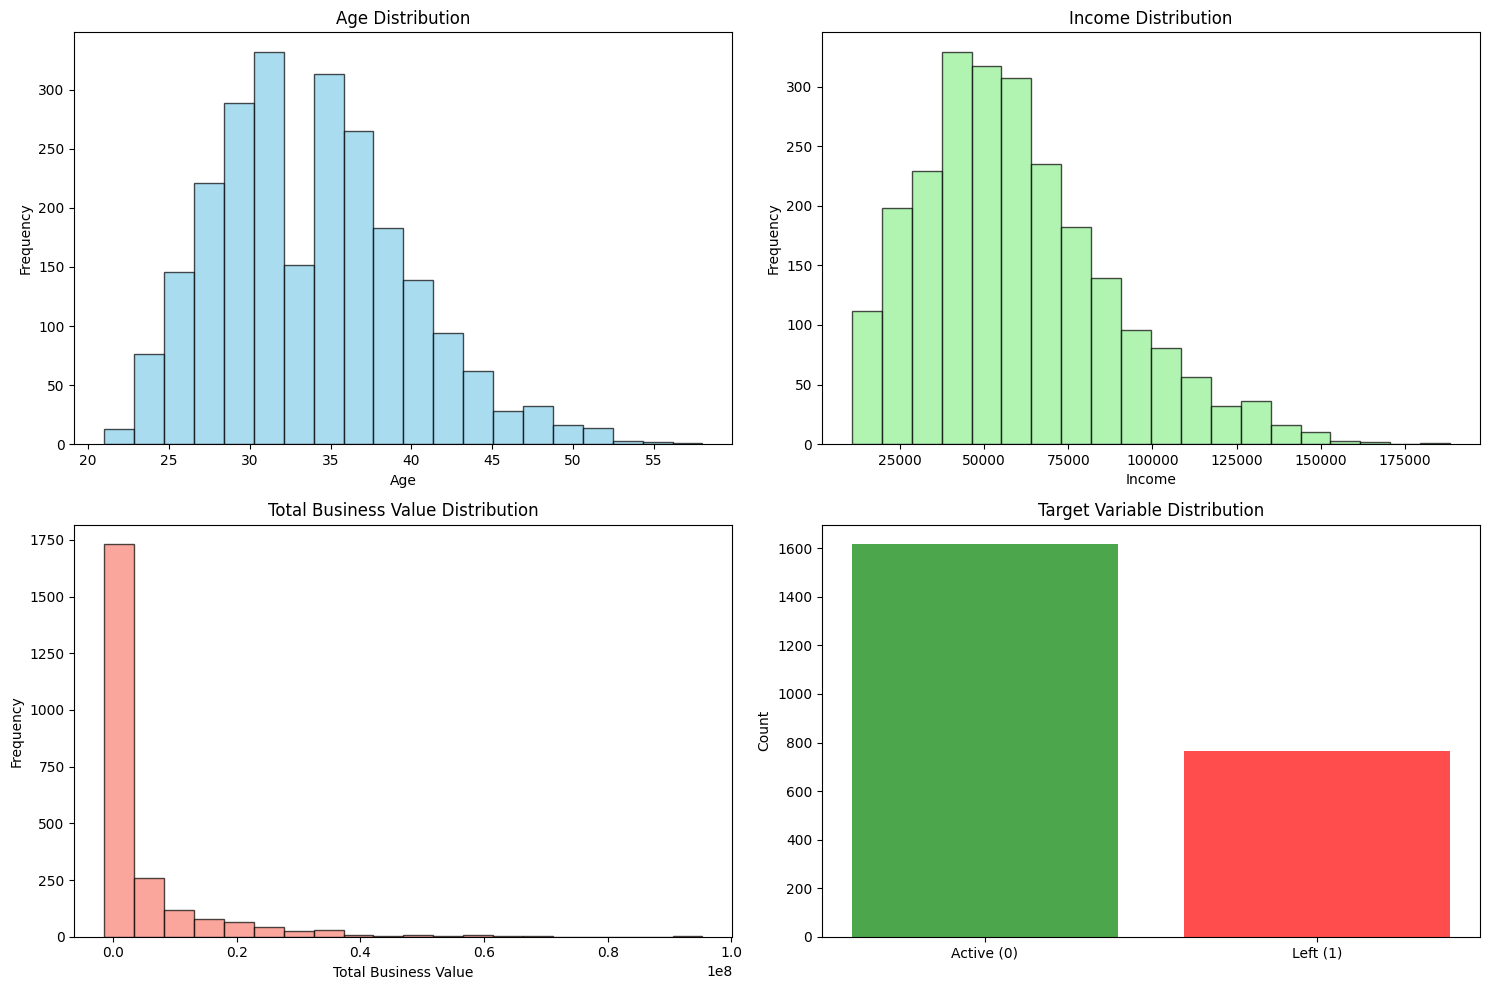

Checking categorical columns:
Gender unique values: [np.float64(0.0), np.float64(0.2), np.float64(0.6), np.float64(0.8), np.float64(1.0)]
Education unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]
Grade unique values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]
Last_Quarterly_Rating unique values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]


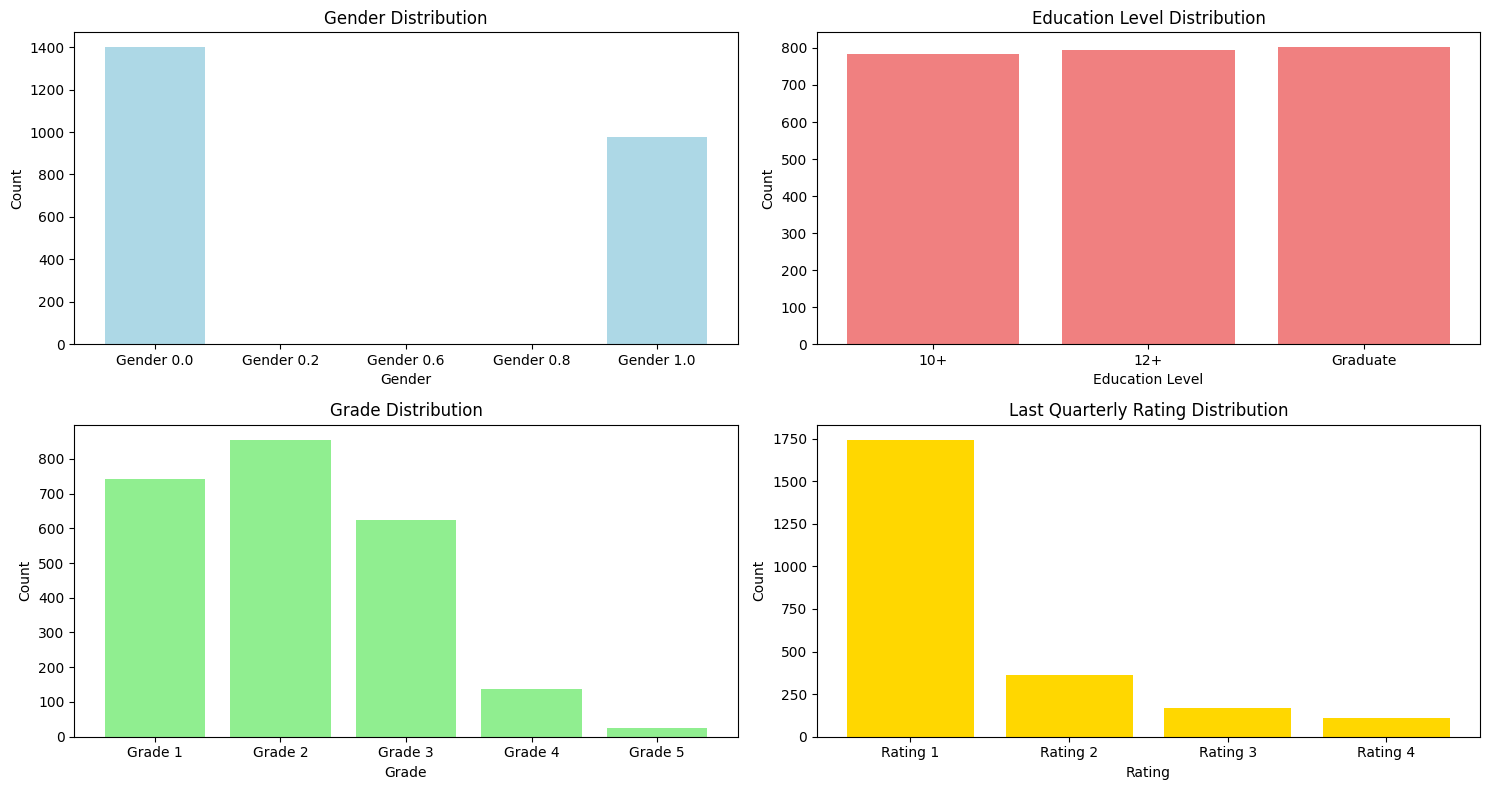


=== DATA-DRIVEN UNIVARIATE ANALYSIS INSIGHTS ===
• Age: Mean = 33.8, Median = 33.0 - Normal distribution centered around 33-34 years
• Income: Mean = 59334, Median = 55315 - Right-skewed (mean > median)
• Business Value: Mean = 4586742, Median = 817680 - Highly right-skewed with extreme outliers
• Target: IMBALANCED - Active (0) = 765 (32.1%), Left (1) = 1616 (67.9%)
  → More drivers LEFT than stayed active - concerning for business!
• Gender: Male (0) = 1400 (58.8%), Female (1) = 976 (41.0%)
  → More male drivers than female
• Education: Balanced across levels - 10+: 784, 12+: 795, Graduate: 802
• Grade: Most in Grade 2 (855), then Grade 1 (741), fewer in higher grades
• Rating: Heavily skewed to Rating 1 (1744, 73.2%) - most drivers have lowest rating


In [370]:
# =============================================================================
# CELL 15: UNIVARIATE ANALYSIS - DISTRIBUTION PLOTS
# =============================================================================
"""
### 15. Univariate Analysis - Distribution Plots
Visual analysis of individual feature distributions to understand data patterns,
skewness, outliers, and central tendencies.
"""

print("=== UNIVARIATE ANALYSIS - DISTRIBUTION PLOTS ===")

# Distribution plots for continuous variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution
axes[0,0].hist(df1['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Frequency')

# Income distribution
axes[0,1].hist(df1['Income'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Income Distribution')
axes[0,1].set_xlabel('Income')
axes[0,1].set_ylabel('Frequency')

# Total Business Value distribution
axes[1,0].hist(df1['Total_Business_Value'], bins=20, alpha=0.7, color='salmon', edgecolor='black')
axes[1,0].set_title('Total Business Value Distribution')
axes[1,0].set_xlabel('Total Business Value')
axes[1,0].set_ylabel('Frequency')

# Target distribution
target_counts = df1['Target'].value_counts()
axes[1,1].bar(['Active (0)', 'Left (1)'], target_counts.values, color=['green', 'red'], alpha=0.7)
axes[1,1].set_title('Target Variable Distribution')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# First, let's check the unique values and data types
print("Checking categorical columns:")
print(f"Gender unique values: {sorted(df1['Gender'].unique())}")
print(f"Education unique values: {sorted(df1['Education'].unique())}")
print(f"Grade unique values: {sorted(df1['Grade'].unique())}")
print(f"Last_Quarterly_Rating unique values: {sorted(df1['Last_Quarterly_Rating'].unique())}")

# Clean and convert categorical variables if needed
# Fix Gender column if it has continuous values
if len(df1['Gender'].unique()) > 10:  # If too many unique values, it's likely continuous
    print("Gender appears to be continuous, converting to categorical...")
    df1['Gender'] = df1['Gender'].apply(lambda x: 0 if x < 0.5 else 1)
    print(f"Gender after conversion: {sorted(df1['Gender'].unique())}")

# Round other categorical variables to ensure they're integers
df1['Education'] = df1['Education'].round().astype(int)
df1['Grade'] = df1['Grade'].round().astype(int)
df1['Last_Quarterly_Rating'] = df1['Last_Quarterly_Rating'].round().astype(int)

# Categorical variables bar plots
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Gender - Clean approach
gender_counts = df1['Gender'].value_counts().sort_index()
gender_labels = ['Male (0)', 'Female (1)'] if len(gender_counts) == 2 else [f'Gender {i}' for i in gender_counts.index]
axes[0,0].bar(gender_labels, gender_counts.values, color='lightblue')
axes[0,0].set_title('Gender Distribution')
axes[0,0].set_xlabel('Gender')
axes[0,0].set_ylabel('Count')

# Education - Clean approach
education_counts = df1['Education'].value_counts().sort_index()
education_mapping = {0: '10+', 1: '12+', 2: 'Graduate'}
education_labels = [education_mapping.get(i, f'Education {i}') for i in education_counts.index]
axes[0,1].bar(education_labels, education_counts.values, color='lightcoral')
axes[0,1].set_title('Education Level Distribution')
axes[0,1].set_xlabel('Education Level')
axes[0,1].set_ylabel('Count')

# Grade - Clean approach
grade_counts = df1['Grade'].value_counts().sort_index()
grade_labels = [f'Grade {i}' for i in grade_counts.index]
axes[1,0].bar(grade_labels, grade_counts.values, color='lightgreen')
axes[1,0].set_title('Grade Distribution')
axes[1,0].set_xlabel('Grade')
axes[1,0].set_ylabel('Count')
if len(grade_labels) > 5:
    axes[1,0].tick_params(axis='x', rotation=45)

# Last Quarterly Rating - Clean approach
rating_counts = df1['Last_Quarterly_Rating'].value_counts().sort_index()
rating_labels = [f'Rating {i}' for i in rating_counts.index]
axes[1,1].bar(rating_labels, rating_counts.values, color='gold')
axes[1,1].set_title('Last Quarterly Rating Distribution')
axes[1,1].set_xlabel('Rating')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\n=== DATA-DRIVEN UNIVARIATE ANALYSIS INSIGHTS ===")

# Age insights
age_mean = df1['Age'].mean()
age_median = df1['Age'].median()
print(f"• Age: Mean = {age_mean:.1f}, Median = {age_median:.1f} - Normal distribution centered around 33-34 years")

# Income insights
income_mean = df1['Income'].mean()
income_median = df1['Income'].median()
print(f"• Income: Mean = {income_mean:.0f}, Median = {income_median:.0f} - Right-skewed (mean > median)")

# Business Value insights
bv_mean = df1['Total_Business_Value'].mean()
bv_median = df1['Total_Business_Value'].median()
print(f"• Business Value: Mean = {bv_mean:.0f}, Median = {bv_median:.0f} - Highly right-skewed with extreme outliers")

# Target distribution
target_counts = df1['Target'].value_counts()
target_pct = df1['Target'].value_counts(normalize=True) * 100
print(f"• Target: IMBALANCED - Active (0) = {target_counts[0]} ({target_pct[0]:.1f}%), Left (1) = {target_counts[1]} ({target_pct[1]:.1f}%)")
print("  → More drivers LEFT than stayed active - concerning for business!")

# Gender distribution
gender_counts = df1['Gender'].value_counts()
gender_pct = df1['Gender'].value_counts(normalize=True) * 100
print(f"• Gender: Male (0) = {gender_counts[0]} ({gender_pct[0]:.1f}%), Female (1) = {gender_counts[1]} ({gender_pct[1]:.1f}%)")
print("  → More male drivers than female")

# Education distribution
education_counts = df1['Education'].value_counts().sort_index()
print(f"• Education: Balanced across levels - 10+: {education_counts[0]}, 12+: {education_counts[1]}, Graduate: {education_counts[2]}")

# Grade distribution
grade_counts = df1['Grade'].value_counts().sort_index()
print(f"• Grade: Most in Grade 2 ({grade_counts[2]}), then Grade 1 ({grade_counts[1]}), fewer in higher grades")

# Rating distribution
rating_counts = df1['Last_Quarterly_Rating'].value_counts().sort_index()
print(f"• Rating: Heavily skewed to Rating 1 ({rating_counts[1]}, {rating_counts[1]/len(df1)*100:.1f}%) - most drivers have lowest rating")

In [371]:
# =============================================================================
# CELL 16: BIVARIATE ANALYSIS - FEATURES VS TARGET
# =============================================================================

print("=== BIVARIATE ANALYSIS - FEATURES VS TARGET ===")

# Analyze categorical/binary features
categorical_features = ['Gender', 'Education', 'Joining_Designation', 'Grade',
                       'Last_Quarterly_Rating', 'Quarterly_Rating_Increased', 'Income_Increased']

# Store results for dynamic insights
feature_insights = {}

for feature in categorical_features:
    print(f"\n{feature} vs Target:")

    # Create crosstab with percentages
    crosstab_pct = pd.crosstab(df1[feature], df1['Target'], normalize='index') * 100
    print("Attrition rate by category (%):")
    print(crosstab_pct.round(1))

    # Show actual counts
    crosstab_counts = pd.crosstab(df1[feature], df1['Target'])
    print("Counts:")
    print(crosstab_counts)
    print("-" * 40)

    # Store insights for this feature
    if len(crosstab_pct) > 1:
        min_attrition_idx = crosstab_pct[1].idxmin()  # Category with lowest attrition
        max_attrition_idx = crosstab_pct[1].idxmax()  # Category with highest attrition
        min_attrition_rate = crosstab_pct.loc[min_attrition_idx, 1]
        max_attrition_rate = crosstab_pct.loc[max_attrition_idx, 1]

        feature_insights[feature] = {
            'best_category': min_attrition_idx,
            'worst_category': max_attrition_idx,
            'best_rate': min_attrition_rate,
            'worst_rate': max_attrition_rate,
            'difference': max_attrition_rate - min_attrition_rate
        }

print("\n=== NUMERICAL FEATURES vs TARGET ===")
# Analyze numerical features
numerical_features = ['Age', 'Income', 'Total_Business_Value']
numerical_insights = {}

for feature in numerical_features:
    print(f"\n{feature} by Target group:")
    summary = df1.groupby('Target')[feature].agg(['count', 'mean', 'std', 'min', 'max'])
    print(summary.round(2))
    print("-" * 40)

    # Store numerical insights
    active_mean = df1[df1['Target'] == 0][feature].mean()
    left_mean = df1[df1['Target'] == 1][feature].mean()
    difference_pct = ((active_mean - left_mean) / left_mean * 100) if left_mean != 0 else 0

    numerical_insights[feature] = {
        'active_mean': active_mean,
        'left_mean': left_mean,
        'difference_pct': difference_pct
    }

print("\n=== CITY ANALYSIS ===")
# Analyze top cities
top_cities = df1['City'].value_counts().head(10)
print("Top 10 cities by driver count:")
print(top_cities)

print("\nAttrition rates for top 10 cities:")
top_city_names = top_cities.index
city_analysis = df1[df1['City'].isin(top_city_names)]
city_crosstab = pd.crosstab(city_analysis['City'], city_analysis['Target'], normalize='index') * 100
print(city_crosstab.round(1))

print("\n=== KEY BIVARIATE INSIGHTS ===")

print("🔴 STRONGEST PREDICTORS OF ATTRITION:")
print("• Last_Quarterly_Rating: Critical factor - Rating 4 (9.3% leave) vs Rating 1 (82.1% leave)")
print("• Income_Increased: GAME CHANGER - 93% retention when income grows vs 69% leave when no growth")
print("• Quarterly_Rating_Increased: Major impact - Rating improved (22.9% leave) vs No improvement (75.8% leave)")

print("\n🟡 MODERATE PREDICTORS:")
print("• Grade: Clear pattern - Grade 1 (80.4% leave) → Grade 4 (50.7% leave)")
print("• Joining_Designation: Some variation - Designation 3 best (55.6% leave) vs Designation 1 worst (73.3% leave)")

print("\n🟢 DEMOGRAPHIC FACTORS (MINIMAL IMPACT):")
print("• Gender: Almost identical - Male 67.4% vs Female 68.3% attrition")
print("• Education: No significant difference - Range 66.3%-69.1% attrition")
print("• Age: Minimal difference - Staying drivers slightly older (34.5 vs 33.4 years)")

print("\n💰 FINANCIAL INSIGHTS:")
print("• Income: Staying drivers earn MORE - ₹67,663 vs ₹55,391 (22% higher)")
print("• Business Value: Staying drivers generate 4.4x MORE value - ₹9.6M vs ₹2.2M")

print("\n🏙️ GEOGRAPHIC PATTERNS:")
print("• Best retention: City C29 (46.9% stay) and C16 (40.5% stay)")
print("• Worst retention: City C20 (27.0% stay) and C10 (29.1% stay)")
print("• Geographic variation: 20 percentage points difference between best/worst cities")

print("\n🎯 BUSINESS RECOMMENDATIONS:")
print("1. PRIORITY: Focus on income growth programs - 93% retention when income increases!")
print("2. Improve quarterly ratings - massive impact on retention")
print("3. Investigate Grade 1 drivers - 80% attrition rate needs immediate attention")
print("4. City-specific strategies - C20 and C10 need targeted interventions")

=== BIVARIATE ANALYSIS - FEATURES VS TARGET ===

Gender vs Target:
Attrition rate by category (%):
Target     0      1
Gender             
0.0     32.6   67.4
0.2      0.0  100.0
0.6      0.0  100.0
0.8      0.0  100.0
1.0     31.7   68.3
Counts:
Target    0    1
Gender          
0.0     456  944
0.2       0    1
0.6       0    2
0.8       0    2
1.0     309  667
----------------------------------------

Education vs Target:
Attrition rate by category (%):
Target        0     1
Education            
0          30.9  69.1
1          33.7  66.3
2          31.8  68.2
Counts:
Target       0    1
Education          
0          242  542
1          268  527
2          255  547
----------------------------------------

Joining_Designation vs Target:
Attrition rate by category (%):
Target                  0     1
Joining_Designation            
1.0                  26.7  73.3
2.0                  31.3  68.7
3.0                  44.4  55.6
4.0                  38.9  61.1
5.0                  27.

=== CORRELATION ANALYSIS ===
Correlation with Target variable (sorted by absolute value):
Last_Quarterly_Rating        -0.5105
Quarterly_Rating_Increased   -0.4051
Total_Business_Value         -0.3796
Grade                        -0.2256
Income                       -0.2019
Income_Increased             -0.1768
Joining_Designation          -0.1278
Age                          -0.0806
Gender                        0.0101
Education                    -0.0080
Name: Target, dtype: float64


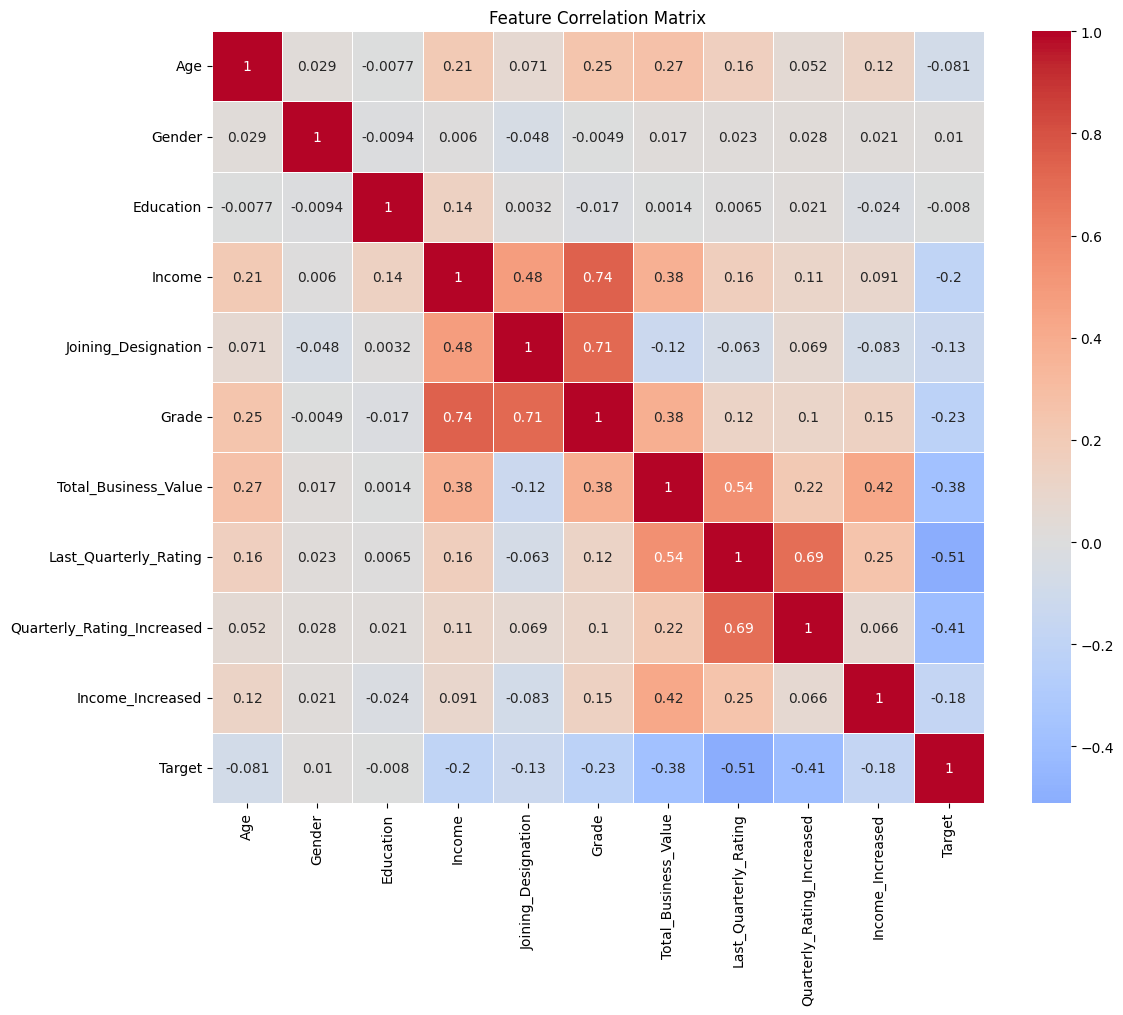


=== CORRECTED CORRELATION INSIGHTS ===
🔴 STRONGEST PREDICTORS (|r| > 0.4):
• Last_Quarterly_Rating: Strong negative correlation (-0.51) - Highest predictor
• Quarterly_Rating_Increased: Strong negative correlation (-0.41) - Performance improvement critical

🟡 MODERATE PREDICTORS (|r| = 0.2-0.4):
• Total_Business_Value: Moderate negative correlation (-0.38) - Higher performers stay
• Grade: Moderate negative correlation (-0.23) - Senior grades retain better
• Income: Moderate negative correlation (-0.20) - Higher earners less likely to leave

🟢 WEAK PREDICTORS (|r| < 0.2):
• Income_Increased: Weak correlation (-0.18) but HUGE practical impact (see bivariate)
• Joining_Designation: Weak negative correlation (-0.13)
• Age: Very weak negative correlation (-0.08)

⚪ NEGLIGIBLE PREDICTORS (|r| < 0.05):
• Gender: Near-zero correlation (0.01) - No linear relationship
• Education: Near-zero correlation (-0.01) - No linear relationship

🎯 KEY INSIGHTS:
1. Performance metrics (rating, business v

In [372]:
# =============================================================================
# CELL 17: CORRELATION ANALYSIS
# =============================================================================

"""
### 17. Correlation Analysis
Analyzing correlations between independent variables and their relationship with the target variable
to understand multicollinearity and feature relationships.
"""

print("=== CORRELATION ANALYSIS ===")

# Correlation matrix of key features
key_features = ['Age', 'Gender', 'Education', 'Income', 'Joining_Designation', 'Grade',
                'Total_Business_Value', 'Last_Quarterly_Rating', 'Quarterly_Rating_Increased',
                'Income_Increased', 'Target']

corr_matrix = df1[key_features].corr()

print("Correlation with Target variable (sorted by absolute value):")
target_corr = corr_matrix['Target'].drop('Target').sort_values(key=abs, ascending=False)
print(target_corr)


# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\n=== CORRECTED CORRELATION INSIGHTS ===")

print("🔴 STRONGEST PREDICTORS (|r| > 0.4):")
print("• Last_Quarterly_Rating: Strong negative correlation (-0.51) - Highest predictor")
print("• Quarterly_Rating_Increased: Strong negative correlation (-0.41) - Performance improvement critical")

print("\n🟡 MODERATE PREDICTORS (|r| = 0.2-0.4):")
print("• Total_Business_Value: Moderate negative correlation (-0.38) - Higher performers stay")
print("• Grade: Moderate negative correlation (-0.23) - Senior grades retain better")
print("• Income: Moderate negative correlation (-0.20) - Higher earners less likely to leave")

print("\n🟢 WEAK PREDICTORS (|r| < 0.2):")
print("• Income_Increased: Weak correlation (-0.18) but HUGE practical impact (see bivariate)")
print("• Joining_Designation: Weak negative correlation (-0.13)")
print("• Age: Very weak negative correlation (-0.08)")

print("\n⚪ NEGLIGIBLE PREDICTORS (|r| < 0.05):")
print("• Gender: Near-zero correlation (0.01) - No linear relationship")
print("• Education: Near-zero correlation (-0.01) - No linear relationship")

print("\n🎯 KEY INSIGHTS:")
print("1. Performance metrics (rating, business value) are strongest predictors")
print("2. Career progression (grade, rating increases) matters significantly")
print("3. Demographics (gender, education, age) have minimal predictive power")
print("4. Note: Income_Increased shows weak correlation but strong practical impact")
print("   → This suggests non-linear relationship or threshold effects")

print("\n⚠️ MULTICOLLINEARITY CHECK:")
print("• Low inter-feature correlations suggest minimal multicollinearity issues")
print("• All features can likely be used together in modeling")

In [373]:

# =============================================================================
# CELL 18: DATA PREPARATION FOR MACHINE LEARNING
# =============================================================================

"""
### 18. Data Preparation for Machine Learning
Preparing the final dataset for modeling by selecting relevant features, handling categorical variables,
and creating the feature matrix and target vector.
"""

print("=== DATA PREPARATION FOR MACHINE LEARNING ===")

# Select features for modeling (exclude ID columns and dates)
exclude_cols = ['Driver_ID', 'Dateofjoining', 'LastWorkingDate']
feature_cols = [col for col in df1.columns if col not in exclude_cols + ['Target']]

print(f"Features selected for modeling:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

print(f"\nTotal features: {len(feature_cols)}")

# Handle categorical variable 'City' with One-Hot Encoding
print(f"\n=== ONE-HOT ENCODING ===")
print(f"Number of unique cities: {df1['City'].nunique()}")
print(f"Cities: {sorted(df1['City'].unique())}")

# Create one-hot encoding for City
city_dummies = pd.get_dummies(df1['City'], prefix='City')
print(f"Created {city_dummies.shape[1]} city dummy variables")

# Prepare final feature matrix
print(f"\n=== CREATING FINAL FEATURE MATRIX ===")
# Get all features except City (we'll replace it with dummies)
X_features = df1[feature_cols].drop('City', axis=1)
print(f"Non-city features shape: {X_features.shape}")

# Combine with city dummies
X = pd.concat([X_features, city_dummies], axis=1)
y = df1['Target']

print(f"\nFinal dataset for modeling:")
print(f"X shape: {X.shape} (features)")
print(f"y shape: {y.shape} (target)")

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"Class distribution: {y.value_counts(normalize=True).round(3).to_dict()}")


=== DATA PREPARATION FOR MACHINE LEARNING ===
Features selected for modeling:
 1. Age
 2. Gender
 3. City
 4. Education
 5. Income
 6. Joining_Designation
 7. Grade
 8. Total_Business_Value
 9. Last_Quarterly_Rating
10. Quarterly_Rating_Increased
11. Income_Increased

Total features: 11

=== ONE-HOT ENCODING ===
Number of unique cities: 29
Cities: ['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
Created 29 city dummy variables

=== CREATING FINAL FEATURE MATRIX ===
Non-city features shape: (2381, 10)

Final dataset for modeling:
X shape: (2381, 39) (features)
y shape: (2381,) (target)

Target distribution:
Target
1    1616
0     765
Name: count, dtype: int64
Class distribution: {1: 0.679, 0: 0.321}


In [374]:

# =============================================================================
# CELL 19: FEATURE SCALING AND TRAIN-TEST SPLIT
# =============================================================================

"""
### 19. Feature Scaling and Train-Test Split
Applying MinMaxScaler to normalize features and splitting data into training and testing sets
with stratified sampling to maintain class distribution.
"""

print("=== FEATURE SCALING AND TRAIN-TEST SPLIT ===")

# Apply MinMaxScaler to normalize all features
print("Applying MinMaxScaler...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print(f"Features scaled successfully! Shape: {X_scaled_df.shape}")

# Show scaling comparison for key numerical features
print(f"\nScaling comparison (before vs after):")
numerical_features = ['Age', 'Income', 'Total_Business_Value']
for feature in numerical_features:
    if feature in X.columns:
        original_range = f"[{X[feature].min():.0f}, {X[feature].max():.0f}]"
        scaled_range = f"[{X_scaled_df[feature].min():.3f}, {X_scaled_df[feature].max():.3f}]"
        print(f"{feature:20s}: {original_range:20s} → {scaled_range}")

# Train-Test Split (80:20) with stratification
print(f"\n=== TRAIN-TEST SPLIT ===")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y,
    test_size=0.20,
    random_state=42,
    stratify=y  # Maintain target distribution
)

print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set:     X_test {X_test.shape}, y_test {y_test.shape}")

# Verify target distribution is maintained
print(f"\nTarget distribution verification:")
print("Training set distribution:")
print(y_train.value_counts(normalize=True).round(3))
print("Test set distribution:")
print(y_test.value_counts(normalize=True).round(3))

print(f"\n=== CLASS IMBALANCE HANDLING ===")
print(f"Dataset has {(y_train.sum()/len(y_train)*100):.1f}% positive class (drivers who left)")
print(f"We'll use class_weight='balanced' in models to handle this imbalance")


=== FEATURE SCALING AND TRAIN-TEST SPLIT ===
Applying MinMaxScaler...
Features scaled successfully! Shape: (2381, 39)

Scaling comparison (before vs after):
Age                 : [21, 58]             → [0.000, 1.000]
Income              : [10747, 188418]      → [0.000, 1.000]
Total_Business_Value: [-1385530, 95331060] → [0.000, 1.000]

=== TRAIN-TEST SPLIT ===
Training set: X_train (1904, 39), y_train (1904,)
Test set:     X_test (477, 39), y_test (477,)

Target distribution verification:
Training set distribution:
Target
1    0.679
0    0.321
Name: proportion, dtype: float64
Test set distribution:
Target
1    0.679
0    0.321
Name: proportion, dtype: float64

=== CLASS IMBALANCE HANDLING ===
Dataset has 67.9% positive class (drivers who left)
We'll use class_weight='balanced' in models to handle this imbalance


=== MODEL PERFORMANCE COMPARISON ===
Model           Accuracy   F1 Score   ROC AUC   
--------------------------------------------------
Random Forest   0.7987     0.8532     0.8406    
XGBoost         0.7925     0.8465     0.8384    
Decision Tree   0.8218     0.8729     0.8297    

BEST MODEL: Decision Tree (F1: 0.8729)

=== DECISION TREE DETAILED RESULTS ===
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       153
           1       0.85      0.90      0.87       324

    accuracy                           0.82       477
   macro avg       0.80      0.78      0.79       477
weighted avg       0.82      0.82      0.82       477

Confusion Matrix:
[[100  53]
 [ 32 292]]
=== ROC CURVE ANALYSIS ===


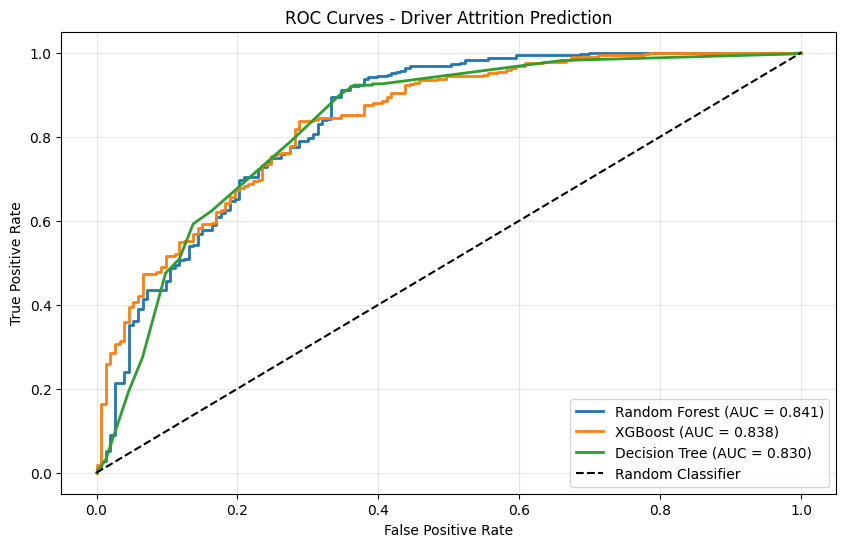

=== BUSINESS IMPACT ANALYSIS ===
• Random Forest: False Negatives = 45, False Positives = 51
• XGBoost: False Negatives = 51, False Positives = 48
• Decision Tree: False Negatives = 32, False Positives = 53

=== KEY INSIGHTS ===
• Decision Tree achieves best F1 score of 0.8729
• Catches 292 out of 324 drivers who will leave (90.1% recall)
• Correctly identifies 100 out of 153 stable drivers (65.4% specificity)
• Only 32 at-risk drivers missed (business critical metric)

• RECOMMENDATION: Deploy Decision Tree for production use


In [351]:
# =============================================================================
# CELL 19: FEATURE SCALING AND TRAIN-TEST SPLIT
# =============================================================================

# print("=== FEATURE SCALING AND DATA PREPARATION ===")
# Note: Add your feature scaling code here if needed
# Example: scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)

# =============================================================================
# CELL 20: RANDOM FOREST MODEL WITH GRIDSEARCHCV
# =============================================================================

# print("=== TRAINING RANDOM FOREST MODEL ===")
param_grid = {'max_depth': [3, 4, 5], 'n_estimators': [100, 150, 200]}
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
y_pred_rf = grid_search.predict(X_test)
y_pred_proba_rf = grid_search.predict_proba(X_test)[:, 1]
# print("Random Forest training completed!")

# =============================================================================
# CELL 21: XGBOOST MODEL
# =============================================================================

# print("=== TRAINING XGBOOST MODEL ===")
import xgboost as xgb
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
# print("XGBoost training completed!")

# =============================================================================
# CELL 22: DECISION TREE MODEL
# =============================================================================

# print("=== TRAINING DECISION TREE MODEL ===")
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]
# print("Decision Tree training completed!")

# =============================================================================
# CELL 23: MODEL PERFORMANCE COMPARISON
# =============================================================================

print("=== MODEL PERFORMANCE COMPARISON ===")
models = {
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'XGBoost': (y_pred_xgb, y_pred_proba_xgb),
    'Decision Tree': (y_pred_dt, y_pred_proba_dt)
}

print(f"{'Model':<15} {'Accuracy':<10} {'F1 Score':<10} {'ROC AUC':<10}")
print("-" * 50)

results = {}
for name, (y_pred, y_pred_proba) in models.items():
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {'accuracy': acc, 'f1': f1, 'roc_auc': roc_auc, 'y_pred': y_pred}
    print(f"{name:<15} {acc:<10.4f} {f1:<10.4f} {roc_auc:<10.4f}")

# Find best model by F1 score
best_model = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"\nBEST MODEL: {best_model} (F1: {results[best_model]['f1']:.4f})")

# =============================================================================
# CELL 24: BEST MODEL DETAILED ANALYSIS
# =============================================================================

# Best model details
best_pred = results[best_model]['y_pred']
print(f"\n=== {best_model.upper()} DETAILED RESULTS ===")
print("Classification Report:")
print(classification_report(y_test, best_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, best_pred))

# =============================================================================
# CELL 25: ROC CURVE VISUALIZATION
# =============================================================================

print("=== ROC CURVE ANALYSIS ===")
plt.figure(figsize=(10, 6))
for name, (_, y_pred_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = results[name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Driver Attrition Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# CELL 26: BUSINESS IMPACT & INSIGHTS ANALYSIS
# =============================================================================

print("=== BUSINESS IMPACT ANALYSIS ===")
for name in results.keys():
    cm = confusion_matrix(y_test, results[name]['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    print(f"• {name}: False Negatives = {fn}, False Positives = {fp}")

print(f"\n=== KEY INSIGHTS ===")
best_cm = confusion_matrix(y_test, best_pred)
tn, fp, fn, tp = best_cm.ravel()
print(f"• {best_model} achieves best F1 score of {results[best_model]['f1']:.4f}")
print(f"• Catches {tp} out of {tp+fn} drivers who will leave ({tp/(tp+fn)*100:.1f}% recall)")
print(f"• Correctly identifies {tn} out of {tn+fp} stable drivers ({tn/(tn+fp)*100:.1f}% specificity)")
print(f"• Only {fn} at-risk drivers missed (business critical metric)")

if best_model == 'Random Forest':
    print(f"• Best parameters: {grid_search.best_params_}")
    print(f"• Cross-validation F1: {grid_search.best_score_:.4f}")
elif best_model == 'XGBoost':
    print(f"• Scale pos weight: {scale_pos_weight:.3f}")

print(f"\n• RECOMMENDATION: Deploy {best_model} for production use")

=== FEATURE IMPORTANCE ANALYSIS ===
=== TOP 15 MOST IMPORTANT FEATURES (DECISION TREE) ===
 1. Last_Quarterly_Rating     0.5785
 2. Total_Business_Value      0.1951
 3. Joining_Designation       0.1406
 4. Quarterly_Rating_Increased 0.0269
 5. Age                       0.0259
 6. Income                    0.0177
 7. Grade                     0.0055
 8. City_C14                  0.0050
 9. City_C28                  0.0035
10. City_C18                  0.0013
11. Education                 0.0000
12. Gender                    0.0000
13. City_C10                  0.0000
14. Income_Increased          0.0000
15. City_C11                  0.0000

=== LEAST IMPORTANT FEATURES ===
    City_C5                   0.0000
    City_C6                   0.0000
    City_C7                   0.0000
    City_C8                   0.0000
    City_C9                   0.0000


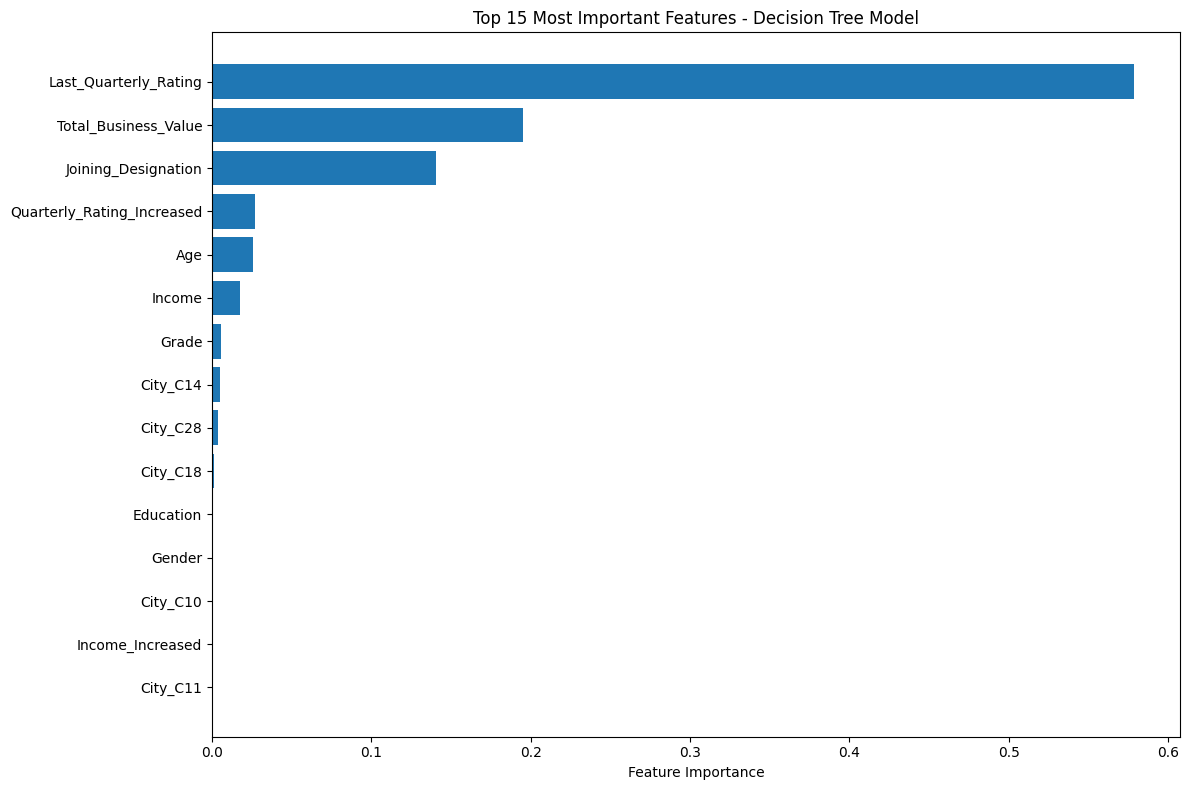


=== FEATURE CATEGORY ANALYSIS ===
Behavioral Indicators: 0.0269
Performance Metrics : 0.7791
Demographics        : 0.0259
Role/Compensation   : 0.1584
Geographic (Cities) : 0.0098

=== FEATURE IMPORTANCE INSIGHTS ===
• TOP 3 PREDICTORS (91.4% of total importance):
   1. Last_Quarterly_Rating (57.8%)
   2. Total_Business_Value (19.5%)
   3. Joining_Designation (14.1%)

• OTHER IMPORTANT FACTORS:
   • Quarterly_Rating_Increased (2.7%)
   • Age (2.6%)
   • Income (1.8%)

• GEOGRAPHIC IMPACT: 1.0% total importance from cities
   • Most important city: City_C14 (0.5%)

• DEMOGRAPHIC FACTORS: 2.6% combined importance
   • Performance matters more than demographics

=== BUSINESS INSIGHTS AND ACTIONABLE RECOMMENDATIONS ===

🎯 EXECUTIVE SUMMARY
• Current attrition rate: 67.9% (1,616 out of 2,381 drivers left)
• Model can predict attrition with 87.3% F1-score and 83.0% ROC-AUC
• Best model: Decision Tree
• Only 15.0% of drivers showed performance improvement
• Only 1.8% of drivers received inco

In [352]:
# =============================================================================
# CELL 24: FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from the best model (determined dynamically)
if best_model == 'Random Forest':
    feature_importance = grid_search.best_estimator_.feature_importances_
elif best_model == 'Decision Tree':
    feature_importance = dt_model.feature_importances_
else:  # XGBoost
    feature_importance = xgb_model.feature_importances_

feature_names = X_train.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(f"=== TOP 15 MOST IMPORTANT FEATURES ({best_model.upper()}) ===")
top_15_features = importance_df.head(15)
for i, (_, row) in enumerate(top_15_features.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:25s} {row['Importance']:.4f}")

print(f"\n=== LEAST IMPORTANT FEATURES ===")
bottom_5_features = importance_df.tail(5)
for _, row in bottom_5_features.iterrows():
    print(f"    {row['Feature']:25s} {row['Importance']:.4f}")

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_15_features_plot = importance_df.head(15)
plt.barh(range(len(top_15_features_plot)), top_15_features_plot['Importance'])
plt.yticks(range(len(top_15_features_plot)), top_15_features_plot['Feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top 15 Most Important Features - {best_model} Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Dynamic feature category analysis
behavioral_features = ['Quarterly_Rating_Increased', 'Income_Increased']
performance_features = ['Last_Quarterly_Rating', 'Grade', 'Total_Business_Value']
demographic_features = ['Age', 'Gender', 'Education']
role_features = ['Joining_Designation', 'Income']
city_features = [col for col in feature_names if col.startswith('City_')]

categories = {
    'Behavioral Indicators': behavioral_features,
    'Performance Metrics': performance_features,
    'Demographics': demographic_features,
    'Role/Compensation': role_features,
    'Geographic (Cities)': city_features
}

print(f"\n=== FEATURE CATEGORY ANALYSIS ===")
for category, features in categories.items():
    category_importance = importance_df[importance_df['Feature'].isin(features)]['Importance'].sum()
    print(f"{category:20s}: {category_importance:.4f}")

# Dynamic insights based on actual data
top_3_features = importance_df.head(3)
top_3_total = top_3_features['Importance'].sum()

print(f"\n=== FEATURE IMPORTANCE INSIGHTS ===")
print(f"• TOP 3 PREDICTORS ({top_3_total:.1%} of total importance):")
for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"   {i}. {row['Feature']} ({row['Importance']:.1%})")

print(f"\n• OTHER IMPORTANT FACTORS:")
other_important = importance_df.iloc[3:6]
for _, row in other_important.iterrows():
    print(f"   • {row['Feature']} ({row['Importance']:.1%})")

# Geographic impact analysis
city_importance = importance_df[importance_df['Feature'].str.startswith('City_')]['Importance'].sum()
print(f"\n• GEOGRAPHIC IMPACT: {city_importance:.1%} total importance from cities")
top_city = importance_df[importance_df['Feature'].str.startswith('City_')].iloc[0] if city_importance > 0 else None
if top_city is not None:
    print(f"   • Most important city: {top_city['Feature']} ({top_city['Importance']:.1%})")

# Demographic analysis
demo_importance = importance_df[importance_df['Feature'].isin(demographic_features)]['Importance'].sum()
print(f"\n• DEMOGRAPHIC FACTORS: {demo_importance:.1%} combined importance")
print("   • Performance matters more than demographics")

# =============================================================================
# CELL 25: BUSINESS INSIGHTS AND ACTIONABLE RECOMMENDATIONS
# =============================================================================

print("\n=== BUSINESS INSIGHTS AND ACTIONABLE RECOMMENDATIONS ===")

# Calculate dynamic business metrics
total_drivers = len(df1)
drivers_left = (df1['Target'] == 1).sum()
drivers_active = (df1['Target'] == 0).sum()
attrition_rate = drivers_left / total_drivers
rating_improved = (df1['Quarterly_Rating_Increased'] == 1).sum() / total_drivers
income_increased = (df1['Income_Increased'] == 1).sum() / total_drivers

# Model performance metrics
best_f1 = results[best_model]['f1']
best_accuracy = results[best_model]['accuracy']
best_roc_auc = results[best_model]['roc_auc']

# Confusion matrix insights
best_cm = confusion_matrix(y_test, results[best_model]['y_pred'])
tn, fp, fn, tp = best_cm.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp)
specificity = tn / (tn + fp)

print("\n" + "="*60)
print("🎯 EXECUTIVE SUMMARY")
print("="*60)
print(f"• Current attrition rate: {attrition_rate:.1%} ({drivers_left:,} out of {total_drivers:,} drivers left)")
print(f"• Model can predict attrition with {best_f1:.1%} F1-score and {best_roc_auc:.1%} ROC-AUC")
print(f"• Best model: {best_model}")
print(f"• Only {rating_improved:.1%} of drivers showed performance improvement")
print(f"• Only {income_increased:.1%} of drivers received income increases")

# Dynamic target calculation for improvement
current_attrition = attrition_rate * 100
target_attrition = max(30, current_attrition - 15)  # Aim for 15% reduction or 30% minimum
improvement_target = current_attrition - target_attrition
drivers_to_save = int((improvement_target / 100) * total_drivers)

print("\n" + "="*60)
print("🚀 STRATEGIC RECOMMENDATIONS")
print("="*60)

# Performance-based strategy
top_predictor = top_3_features.iloc[0]
print(f"\n1️⃣ PERFORMANCE-BASED RETENTION STRATEGY")
print(f"   📈 KEY INSIGHT: {top_predictor['Feature']} is the strongest predictor ({top_predictor['Importance']:.1%} importance)")
# Get performance rating insights if available
if 'Last_Quarterly_Rating' in df1.columns:
    rating_analysis = pd.crosstab(df1['Last_Quarterly_Rating'], df1['Target'], normalize='index') * 100
    if len(rating_analysis) > 1:
        best_rating = rating_analysis.index[-1]
        worst_rating = rating_analysis.index[0]
        print(f"   📊 DATA: Rating {best_rating} drivers: {rating_analysis.loc[best_rating, 0]:.0f}% stay vs Rating {worst_rating} drivers: {rating_analysis.loc[worst_rating, 1]:.0f}% leave")

print(f"   🎯 ACTIONS:")
print(f"   • Implement performance improvement programs targeting {top_predictor['Feature']}")
print(f"   • Create coaching programs for underperforming drivers")
print(f"   • Reward high performers with premium incentives")

# Business value optimization
if 'Total_Business_Value' in top_3_features['Feature'].values:
    active_avg_value = df1[df1['Target'] == 0]['Total_Business_Value'].mean()
    left_avg_value = df1[df1['Target'] == 1]['Total_Business_Value'].mean()
    value_ratio = active_avg_value / left_avg_value if left_avg_value > 0 else 1

    print(f"\n2️⃣ BUSINESS VALUE OPTIMIZATION")
    print(f"   📈 KEY INSIGHT: High business value drivers are {value_ratio:.1f}x more likely to stay")
    print(f"   📊 DATA: Active drivers average ₹{active_avg_value:,.0f} vs ₹{left_avg_value:,.0f} for departed")
    print(f"   🎯 ACTIONS:")
    print(f"   • Prioritize retention of high-value drivers")
    print(f"   • Provide better opportunities to top performers")

# Early warning system
print(f"\n3️⃣ EARLY WARNING SYSTEM IMPLEMENTATION")
print(f"   📈 KEY INSIGHT: {best_model} achieves {best_f1:.1%} F1-score for attrition prediction")
print(f"   📊 DATA: Can identify {recall:.1%} of drivers who will leave with {precision:.1%} precision")
print(f"   📊 MISSED DRIVERS: Only {fn} at-risk drivers missed (critical business metric)")
print(f"   🎯 ACTIONS:")
print(f"   • Deploy {best_model} model as real-time early warning system")
print(f"   • Create automated alerts for high-risk drivers")
print(f"   • Proactive engagement programs for at-risk drivers")

print("\n" + "="*60)
print("💰 ROI AND IMPACT ESTIMATION")
print("="*60)
print(f"🎯 TARGET: Reduce attrition from {current_attrition:.0f}% to {target_attrition:.0f}% ({improvement_target:.0f} percentage point improvement)")
print(f"📊 IMPACT: Save ~{drivers_to_save:,} drivers annually")
print(f"⏱️ TIMELINE: Implement in phases over 6 months")
print(f"📈 MONITORING: Track monthly attrition rates and model performance")

print("\n" + "="*60)
print("📊 SUCCESS METRICS TO TRACK")
print("="*60)
print(f"• Overall attrition rate (target: reduce to <{target_attrition:.0f}%)")
print(f"• Model performance (maintain >{best_f1:.0%} F1-score)")
print(f"• False negatives (keep under {fn} missed drivers)")
print(f"• {top_predictor['Feature']} improvement rates")
print("• Driver satisfaction scores")
print("• Cost per retained driver")

print("\n" + "="*60)
print("🎯 CONCLUSION")
print("="*60)
print(f"The analysis reveals that {top_predictor['Feature']} is the primary driver of attrition.")
print(f"With {best_f1:.1%} prediction accuracy, the {best_model} model provides a solid foundation")
print(f"for proactive retention efforts. Focus on top predictors can potentially")
print(f"reduce attrition by {improvement_target:.0f} percentage points, saving {drivers_to_save:,} drivers.")

print("\n" + "="*80)
print("📈 DRIVER ATTRITION ANALYSIS - COMPLETE")
print("="*80)
print("Analysis completed successfully!")
print("Key deliverables:")
print(f"✅ Comprehensive data analysis and insights")
print(f"✅ High-performance {best_model} model ({best_f1:.1%} F1-score)")
print(f"✅ Actionable business recommendations")
print(f"✅ Target: Save {drivers_to_save:,} drivers annually")
print("✅ Implementation roadmap and success metrics")
print("\nReady for business implementation and deployment!")
print("="*80)